In the previous episode, we wrote a query to select stars from the region of the sky where we expect GD-1 to be, and saved the results in a FITS file.

Now we will read that data back in and implement the next step in the analysis, identifying stars with the proper motion we expect for GD-1.

### Outline
1. We will read back the results from the previous lesson, which we saved in a FITS file.

2. Then we will transform the coordinates and proper motion data from ICRS back to the coordinate frame of GD-1.

3. We will put those results into a Pandas DataFrame.

In [2]:
import astropy.units as u
from astropy.coordinates import SkyCoord
from gala.coordinates import GD1Koposov10
from astropy.table import Table

In [3]:
filename = 'gd1_results.fits'
polygon_results = Table.read(filename)

gd1_frame = GD1Koposov10()

In [4]:
polygon_results.info()

<Table length=140339>
   name    dtype    unit                              description                                class    
--------- ------- -------- ------------------------------------------------------------------ ------------
source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
       ra float64      deg                                                    Right ascension       Column
      dec float64      deg                                                        Declination       Column
     pmra float64 mas / yr                         Proper motion in right ascension direction       Column
    pmdec float64 mas / yr                             Proper motion in declination direction       Column
 parallax float64      mas                                                           Parallax       Column


In [5]:
import matplotlib.pyplot as plt

Pyplot provides two functions that can make scatter plots, `plt.scatter` and `plt.plot`.

* `scatter` is more versatile; for example, you can make every point in a scatter plot a different color.

* `plot` is more limited, but for simple cases, it can be substantially faster.


Since we are plotting more than 100,000 points and they are all the same size and color, we will use plot.

Here is a scatter plot of the stars we selected in the GD-1 region with right ascension on the x-axis and declination on the y-axis, both ICRS coordinates in degrees.

Text(0, 0.5, 'dec(degree ICRS)')

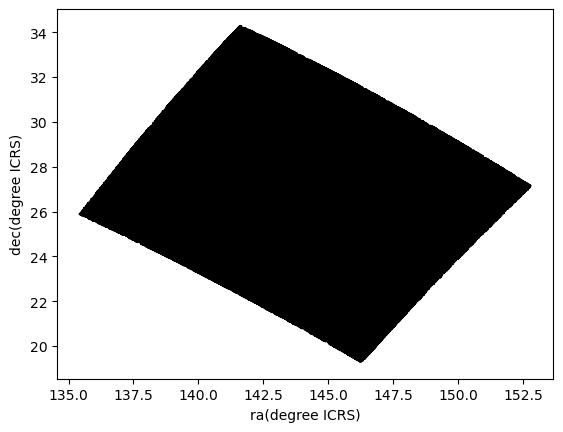

In [6]:
x=polygon_results['ra']
y=polygon_results['dec']
plt.plot(x, y, 'k')

plt.xlabel('ra(degree ICRS)')
plt.ylabel('dec(degree ICRS)')

Looking at this plot, we can see that the region we selected, which is a rectangle in GD-1 coordinates, is a non-rectanglar region in ICRS coordinates.

However, this scatter plot has a problem. It is “overplotted”, which means that there are so many overlapping points, we cannot distinguish between high and low density areas.

To fix this, we can provide optional arguments to control the size and transparency of the points.

# Transform Back
Remember that we selected data from a rectangle of coordinates in the GD-1 frame, then transformed them to ICRS when we constructed the query. The coordinates in the query results are in ICRS.

To plot them, we will transform them back to the GD-1 frame; that way, the axes of the figure are aligned with the orbit of GD-1, which is useful for two reasons:

* By transforming the coordinates, we can identify stars that are likely to be in GD-1 by selecting stars near the centerline of the stream, where φ2 is close to 0.

* By transforming the proper motions, we can identify stars with non-zero proper motion along the φ1 axis, which are likely to be part of GD-1.

To do the transformation, we will put the results into a `SkyCoord` object.

The `SkyCoord` object can keep track not just of location, but also proper motions. This means that we can initialize a `SkyCoord` object with location and proper motions, then use all of these quantities together to transform into the GD-1 frame.

Now we are going to do something similar, but now we will take advantage of the `SkyCoord` object’s capacity to include and track space motion information in addition to `ra` and `dec`. We will now also include:

* `pmra` and `pmdec`, which are proper motion in the ICRS frame, and

* `distance` and `radial_velocity`, which are important for the reflex correction and will be discussed in that section.

In [8]:
distance=8*u.kpc
radial_velocity=0*u.km/u.s

skycoord=SkyCoord(ra=polygon_results['ra'], 
                  dec=polygon_results['dec'], 
                  pm_ra_cosdec=polygon_results['pmra'], 
                  pm_dec=polygon_results['pmdec'], 
                  distance=distance, 
                  radial_velocity=radial_velocity)

In [9]:
transformed=skycoord.transform_to(gd1_frame)

The result is another `SkyCoord` object, now in the GD-1 frame.

# Reflex correction

The next step is to correct the proper motion measurements for the effect of the motion of our solar system around the Galactic center.

When we created `skycoord`, we provided constant values for `distance` and `radial_velocity` rather than measurements from Gaia.

That might seem like a strange thing to do, but here is the motivation:

* Because the stars in GD-1 are so far away, parallaxes measured by Gaia are negligible, making the distance estimates unreliable.
So we replace them with our current best estimate of the mean distance to GD-1, about 8 kpc. See [Koposov, Rix, and Hogg, 2010](https://ui.adsabs.harvard.edu/abs/2010ApJ...712..260K/abstract).

* For the other stars in the table, this distance estimate will be inaccurate, so reflex correction will not be correct. But that should have only a small effect on our ability to identify stars with the proper motion we expect for GD-1.

* The measurement of radial velocity has no effect on the correction for proper motion, but we have to provide a value to avoid errors in the reflex correction calculation. So we provide 0 as an arbitrary place-keeper.

With this preparation, we can use reflex_correct from Gala ([documentation here](https://gala-astro.readthedocs.io/en/latest/api/gala.coordinates.reflex_correct.html)) to correct for the motion of the solar system.

In [10]:
from gala.coordinates import reflex_correct
skycoord_gd1=reflex_correct(transformed)

The result is a `SkyCoord` object that contains

* `phi1` and `phi2`, which represent the transformed coordinates in the GD-1 frame.

* `pm_phi1_cosphi2` and `pm_phi2`, which represent the transformed proper motions that have been corrected for the motion of the solar system around the Galactic center.

Text(0.5, 0, 'phi2 (degree GD1)')

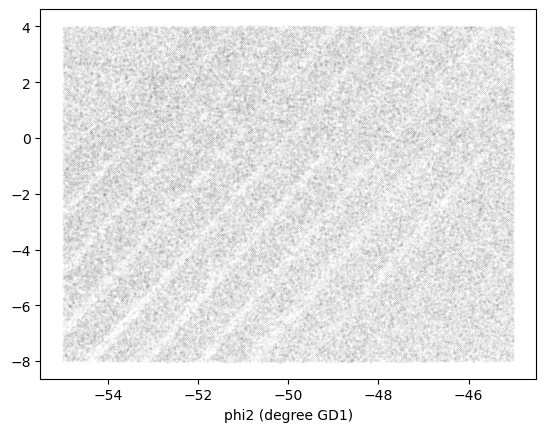

In [23]:
x=skycoord_gd1.phi1
y=skycoord_gd1.phi2

plt.plot(x, y, 'ko', markersize=0.2, alpha=0.1)
plt.xlabel('phi1 (degree GD1)')
plt.xlabel('phi2 (degree GD1)')

*We started with a rectangle in the GD-1 frame. When transformed to the ICRS frame, it is a non-rectangular region. Now, transformed back to the GD-1 frame, it is a rectangle again.*

# Pandas DataFrame

At this point we have two objects containing different sets of the data relating to identifying stars in GD-1. 
1. `polygon_results` is the Astropy `Table` we downloaded from Gaia.
2. `skycoord_gd1` is a `SkyCoord` object that contains the transformed coordinates and proper motions.

In [25]:
type(polygon_results)

astropy.table.table.Table

In [26]:
type(skycoord_gd1)

astropy.coordinates.sky_coordinate.SkyCoord

Now we can extract the columns we want from `skycoord_gd1` and add them as columns in the Astropy Table `polygon_results`. 
* `phi1` and `phi2 `contain the transformed coordinates.
* `pm_phi1_cosphi2` and `pm_phi2` contain the components of proper motion in the transformed frame.

In [27]:
polygon_results['phi1'] = skycoord_gd1.phi1
polygon_results['phi2'] = skycoord_gd1.phi2
polygon_results['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
polygon_results['pm_phi2'] = skycoord_gd1.pm_phi2
polygon_results.info()

<Table length=140339>
   name    dtype    unit                              description                                class    
--------- ------- -------- ------------------------------------------------------------------ ------------
source_id   int64          Unique source identifier (unique within a particular Data Release) MaskedColumn
       ra float64      deg                                                    Right ascension       Column
      dec float64      deg                                                        Declination       Column
     pmra float64 mas / yr                         Proper motion in right ascension direction       Column
    pmdec float64 mas / yr                             Proper motion in declination direction       Column
 parallax float64      mas                                                           Parallax       Column
     phi1 float64      deg                                                    Right ascension       Column
     phi2 float

>If you notice that SkyCoord has an attribute called proper_motion, you might wonder why we are not using it.\
>We could have: proper_motion contains the same data as pm_phi1_cosphi2 and pm_phi2, but in a different format.

In [37]:
import pandas as pd

results_df=polygon_results.to_pandas()

In [38]:
results_df.shape

(140339, 10)

In [39]:
results_df.head() # Just to cross check if we have arrived at the rigth table

,source_id,ra,dec,pmra,pmdec,parallax,phi1,phi2,pm_phi1,pm_phi2
0,637987125186749568,142.483019,21.757716,-2.516838,2.941813,-0.257345,-54.975623,-3.659349,6.429945,6.518157
1,638285195917112960,142.254529,22.476168,2.662702,-12.165984,0.422728,-54.498247,-3.081524,-3.168637,-6.206795
2,638073505568978688,142.645286,22.166932,18.306747,-7.950660,0.103640,-54.551634,-3.554229,9.129447,-16.819570
3,638086386175786752,142.577394,22.227920,0.987786,-2.584105,-0.857327,-54.536457,-3.467966,3.837120,0.526461
4,638049655615392384,142.589136,22.110783,0.244439,-4.941079,0.099625,-54.627448,-3.542738,1.466103,-0.185292


## Turning all this into one single `FUNCTION`

This is a general function that we will use multiple times as we build different queries so we want to write it once and then call the function rather than having to copy and paste the code over and over again.

In [ ]:
def make_dataframe(table):
    """Transform coordinates from ICRS to GD-1 frame.
    
    table: Astropy Table
    
    returns: Pandas DataFrame
    """
    #Create a SkyCoord object with the coordinates and proper motions
    # in the input table
    skycoord = SkyCoord(
               ra=table['ra'], 
               dec=table['dec'],
               pm_ra_cosdec=table['pmra'],
               pm_dec=table['pmdec'], 
               distance=8*u.kpc, 
               radial_velocity=0*u.km/u.s)

    # Define the GD-1 reference frame
    gd1_frame = GD1Koposov10()

    # Transform input coordinates to the GD-1 reference frame
    transformed = skycoord.transform_to(gd1_frame)

    # Correct GD-1 coordinates for solar system motion around galactic center
    skycoord_gd1 = reflex_correct(transformed)

    #Add GD-1 reference frame columns for coordinates and proper motions
    table['phi1'] = skycoord_gd1.phi1
    table['phi2'] = skycoord_gd1.phi2
    table['pm_phi1'] = skycoord_gd1.pm_phi1_cosphi2
    table['pm_phi2'] = skycoord_gd1.pm_phi2

    # Create DataFrame
    df = table.to_pandas()

    return df

To call the above fucntion run the cell below

In [ ]:
#results_df=make_dataframe(polygon_results)

# Saving Data Frame

Then we could write the `Table` to a FITS file, as we did in the previous lesson.

But, like Astropy, Pandas provides functions to write DataFrames in other formats.

One of the best options is `HDF5`, which is Version 5 of Hierarchical Data Format.

HDF5 is a binary format, so files are small and fast to read and write (like FITS, but unlike XML).

An HDF5 file is similar to an SQL database in the sense that it can contain more than one table, although in HDF5 vocabulary, a table is called a Dataset. (`Multi-extension FITS files` can also contain more than one table.)

And HDF5 stores the metadata associated with the table, including column names, row labels, and data types (like FITS).

Finally, HDF5 is a cross-language standard, so if you write an HDF5 file with Pandas, you can read it back with many other software tools (more than FITS).

We can write a Pandas `DataFrame `to an HDF5 file like this:

In [40]:
filename='gd1_data.hdf'
results_df.to_hdf(filename, 'results_df', mode='w')